<a href="https://colab.research.google.com/github/karengarm/NLP_Disaster_Tweets_Classification/blob/main/02_LSTM_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import re
import tensorflow as tf
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import ParameterSampler
from keras.layers.embeddings import Embedding

dir_path = '/content/drive/MyDrive/'
os.chdir(dir_path)

def evaluate(y_test, y_pred, mlflow):
    """
    Evaluation function. For each of the text in evaluation data, it reads the score from
    the predictions made. And based on this, it calculates the values of
    True positive, True negative, False positive, and False negative.

    :param y_test: true labels
    :param y_pred: predicted labels
    :param labels: list of possible labels
    :return: evaluation metrics for classification like, precision, recall, and f_score
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    mauc = auc(fpr, tpr)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    best_trhold =thresholds[ix]

    y_pred  = np.where(y_pred > 0.5, 1, 0) 
    labels = ['Not informative', 'Related and informative']
    confusion = confusion_matrix(y_test, y_pred)


    df_cm = pd.DataFrame(confusion, index=[i for i in labels],
                         columns=[i for i in labels])
    '''
    fig, ax = plt.subplots()
    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True)
    plt.title('Confusion Matrix')
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    mlflow.log_figure(fig, "confusion.png") 
    '''

    # importing accuracy_score, precision_score, recall_score, f1_score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average= None)
    recall = recall_score(y_test, y_pred, average= None)
    f1score = f1_score(y_test, y_pred, average= None)
    
    
    report = classification_report(y_test, y_pred, target_names = labels)
    print(report)

    mlflow.log_metric("auc_test", mauc) 
    mlflow.log_metric("accuracy_test", accuracy)
    mlflow.log_metric("precision_NI", precision[0])  
    mlflow.log_metric("precision_I", precision[1])    
    mlflow.log_metric("recall_NI", recall[0])
    mlflow.log_metric("recall_I", recall[1])
    mlflow.log_metric("f1score_NI", f1score[0]) 
    mlflow.log_metric("f1score_I", f1score[1]) 
    return accuracy, precision, recall, f1score, mauc 
    
def mlflow_log_parameters(cat, parameter):
  # Log parameters
  mlflow.log_param("crisis_type", cat)
  mlflow.log_param("dropout", parameter['dropout'])
  mlflow.log_param("learning_rate", parameter['learning_rate'])
  mlflow.log_param("epochs", parameter['epochs'])
  mlflow.log_param("batch_size", parameter['batch_size'])

def get_input(data, vocabulary_size, max_length):
  # integer encode the documents

  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words= vocabulary_size)
  tokenizer.fit_on_texts(data)
  sequences = tokenizer.texts_to_sequences(data)
  data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=50)
  # pad documents to a max length
  padded_docs = tf.keras.preprocessing.sequence.pad_sequences(data , maxlen=max_length, padding='post')
  return padded_docs

def create_lstm(vocabulary_size, max_length, ndropout, nlr):
  """ LSTM is composed of a main block and a classification layer with dropout
  """
  model = tf.keras.models.Sequential()
  model.add(Embedding(vocabulary_size, 50, input_length=max_length))
  model.add(tf.keras.layers.SpatialDropout1D(0.3))
  model.add(tf.keras.layers.LSTM(256, dropout=ndropout, recurrent_dropout=0.2))
  model.add(tf.keras.layers.Dense(256, activation = 'relu'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  # compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=nlr), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  return model

def training_test_mae( mlflow, history):
  # Plot training and test loss at each epoch 
  fig, ax = plt.subplots()
  ax.plot(history.history['accuracy'], label='Training acc')
  plt.plot(history.history['val_accuracy'], label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()
  mlflow.log_figure(fig, "training_validation_accuracy.png") 

  fig, ax = plt.subplots()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  mlflow.log_figure(fig, "training_validation_loss.png")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mlflow
!databricks configure --host https://community.cloud.databricks.com/
import mlflow
import mlflow.keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.8 MB 684 kB/s 
     |████████████████████████████████| 146 kB 68.2 MB/s 
     |████████████████████████████████| 181 kB 58.3 MB/s 
     |████████████████████████████████| 596 kB 52.0 MB/s 
     |████████████████████████████████| 79 kB 10.1 MB/s 
     |████████████████████████████████| 62 kB 890 kB/s 
     |████████████████████████████████| 210 kB 66.5 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 78 kB 9.1 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.16.6-py3-none-any.whl size=112631 sha256=7c6b8827f5712c3604dc07104d62052c6c42b16ee2a94cf2c7daa35eb4c38d33
  Stored in directory: /root/.cache/pip/wheels/96/c1/f8/d75a22e789ab6a4dff11f18338c3af4360189aa371295cc934
Successfully built databricks-cli
  Attempting uninstal

## Scenario 1

In [7]:
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/karengar@stanford.edu/LSTM_Scenario1_SpatialDropout")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1182520049703883', experiment_id='1182520049703883', lifecycle_stage='active', name='/Users/karengar@stanford.edu/LSTM_Scenario1_SpatialDropout', tags={'mlflow.experiment.sourceName': '/Users/karengar@stanford.edu/LSTM_Scenario1_SpatialDropout',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'karengar@stanford.edu',
 'mlflow.ownerId': '3913783827154434'}>

In [8]:
df_test = pd.read_csv('test_data.csv', header = 0, sep = 't')
df_train= pd.read_csv('train_data.csv', header = 0, sep = 't')

rng = np.random.RandomState(0)
param_dist = {    'dropout': [0.1, 0.2, 0.3],
                  'learning_rate': loguniform.rvs(1e-5, 1e-3, size= 10),
                  'epochs': [5, 8, 25, 50],
                  'batch_size': [64, 128, 450, 512]
                  }
dict_parameters = ParameterSampler(param_distributions=param_dist, n_iter=10, random_state=rng)
vocabulary_size = 20000
max_length = 50

{'learning_rate': 5.06095799640732e-05, 'epochs': 25, 'dropout': 0.2, 'batch_size': 64}
INFO:tensorflow:Assets written to: /tmp/tmpnggd062n/model/data/model/assets


2022/05/31 18:18:22 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/31 18:18:29 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/31 18:18:29 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.7+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLf

Epoch 1/25
46/46 [==============================] - 17s 231ms/step - loss: 0.6905 - accuracy: 0.5772 - precision: 0.5762 - recall: 0.9899 - val_loss: 0.6910 - val_accuracy: 0.4538 - val_precision: 0.4538 - val_recall: 1.0000
Epoch 2/25
46/46 [==============================] - 9s 206ms/step - loss: 0.6811 - accuracy: 0.5755 - precision: 0.5745 - recall: 0.9982 - val_loss: 0.6885 - val_accuracy: 0.4558 - val_precision: 0.4547 - val_recall: 1.0000
Epoch 3/25
46/46 [==============================] - 9s 205ms/step - loss: 0.6507 - accuracy: 0.5945 - precision: 0.5858 - recall: 0.9964 - val_loss: 0.6664 - val_accuracy: 0.5827 - val_precision: 0.5217 - val_recall: 0.9661
Epoch 4/25
46/46 [==============================] - 11s 244ms/step - loss: 0.5979 - accuracy: 0.6829 - precision: 0.6517 - recall: 0.9585 - val_loss: 0.6125 - val_accuracy: 0.7058 - val_precision: 0.6277 - val_recall: 0.8644
Epoch 5/25
46/46 [==============================] - 15s 320ms/step - loss: 0.4857 - accuracy: 0.7886 -

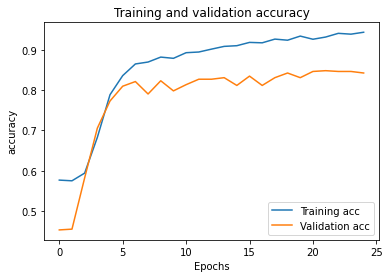

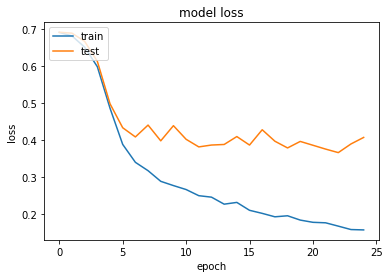

32/32 [==============================] - 1s 15ms/step
                         precision    recall  f1-score   support

        Not informative       0.40      0.50      0.44       373
Related and informative       0.65      0.55      0.60       627

               accuracy                           0.53      1000
              macro avg       0.52      0.52      0.52      1000
           weighted avg       0.55      0.53      0.54      1000



INFO:tensorflow:Assets written to: /tmp/tmpk6uezpff/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpk6uezpff/model/data/model/assets
2022/05/31 18:23:13 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/31 18:23:19 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/31 18:23:19 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0

Epoch 1/25
54/54 [==============================] - 14s 213ms/step - loss: 0.6828 - accuracy: 0.6976 - precision_1: 0.7248 - recall_1: 0.9413 - val_loss: 0.6770 - val_accuracy: 0.6190 - val_precision_1: 0.6190 - val_recall_1: 1.0000
Epoch 2/25
54/54 [==============================] - 11s 207ms/step - loss: 0.6002 - accuracy: 0.7265 - precision_1: 0.7265 - recall_1: 1.0000 - val_loss: 0.7007 - val_accuracy: 0.6190 - val_precision_1: 0.6190 - val_recall_1: 1.0000
Epoch 3/25
54/54 [==============================] - 11s 199ms/step - loss: 0.5875 - accuracy: 0.7265 - precision_1: 0.7265 - recall_1: 1.0000 - val_loss: 0.6959 - val_accuracy: 0.6190 - val_precision_1: 0.6190 - val_recall_1: 1.0000
Epoch 4/25
54/54 [==============================] - 11s 202ms/step - loss: 0.5851 - accuracy: 0.7265 - precision_1: 0.7265 - recall_1: 1.0000 - val_loss: 0.6742 - val_accuracy: 0.6190 - val_precision_1: 0.6190 - val_recall_1: 1.0000
Epoch 5/25
54/54 [==============================] - 11s 204ms/step -

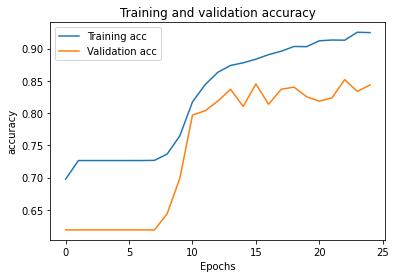

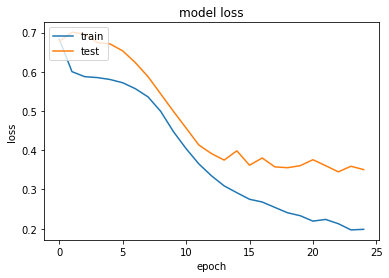

69/69 [==============================] - 1s 13ms/step
                         precision    recall  f1-score   support

        Not informative       0.53      0.37      0.44       841
Related and informative       0.67      0.80      0.73      1359

               accuracy                           0.64      2200
              macro avg       0.60      0.59      0.58      2200
           weighted avg       0.62      0.64      0.62      2200



INFO:tensorflow:Assets written to: /tmp/tmptf5_bxan/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmptf5_bxan/model/data/model/assets
2022/05/31 18:28:58 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/31 18:29:03 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/31 18:29:03 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0

Epoch 1/25
27/27 [==============================] - 9s 226ms/step - loss: 0.6892 - accuracy: 0.6782 - precision_2: 0.6912 - recall_2: 0.9624 - val_loss: 0.6726 - val_accuracy: 0.9734 - val_precision_2: 0.9734 - val_recall_2: 1.0000
Epoch 2/25
27/27 [==============================] - 6s 216ms/step - loss: 0.6757 - accuracy: 0.6882 - precision_2: 0.6882 - recall_2: 1.0000 - val_loss: 0.5921 - val_accuracy: 0.9734 - val_precision_2: 0.9734 - val_recall_2: 1.0000
Epoch 3/25
27/27 [==============================] - 6s 209ms/step - loss: 0.6247 - accuracy: 0.6882 - precision_2: 0.6882 - recall_2: 1.0000 - val_loss: 0.3988 - val_accuracy: 0.9734 - val_precision_2: 0.9734 - val_recall_2: 1.0000
Epoch 4/25
27/27 [==============================] - 6s 214ms/step - loss: 0.6147 - accuracy: 0.6882 - precision_2: 0.6882 - recall_2: 1.0000 - val_loss: 0.3715 - val_accuracy: 0.9734 - val_precision_2: 0.9734 - val_recall_2: 1.0000
Epoch 5/25
27/27 [==============================] - 6s 209ms/step - loss

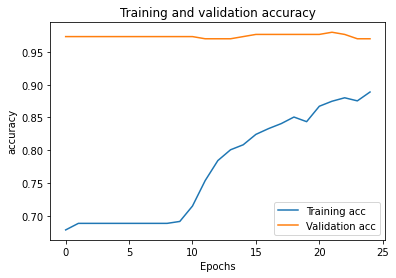

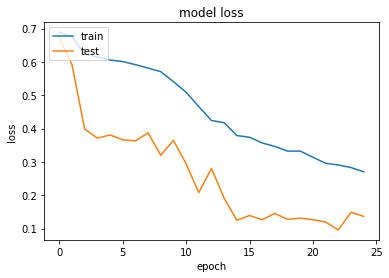

32/32 [==============================] - 1s 14ms/step
                         precision    recall  f1-score   support

        Not informative       0.16      0.01      0.02       271
Related and informative       0.73      0.98      0.83       729

               accuracy                           0.72      1000
              macro avg       0.44      0.49      0.43      1000
           weighted avg       0.57      0.72      0.61      1000



In [11]:
for parameter in dict_parameters:
  print(parameter)
  for cat in df_test.categorization_type.unique(): 
    tmp = df_train[df_train['categorization_type'] == cat]
    X_train = tmp['tweettext_proc'].values
    y_train = np.where(tmp.cat_informativeness =='Related and informative', 1, 0)
    tmp = df_test[df_test['categorization_type'] == cat]
    X_test = tmp['tweettext_proc'].values 
    y_test = np.where(tmp.cat_informativeness =='Related and informative', 1, 0)
    with mlflow.start_run(): 
      mlflow_log_parameters(cat, parameter)
      padded_docs = get_input(X_train, vocabulary_size, max_length)
      # define the model
      model = create_lstm(vocabulary_size, max_length, parameter['dropout'], parameter['learning_rate'])
      # fit the model
      mlflow.keras.log_model(model, "Lstm")
      history = model.fit(padded_docs, np.array(y_train), epochs= parameter['epochs'], batch_size=parameter['batch_size'], validation_split=.15)
      training_test_mae( mlflow, history)
      #Testing
      padded_docs = get_input(X_test, vocabulary_size, max_length)
      y_pred = model.predict(padded_docs, verbose=True)
      accuracy, precision, recall, f1score, mauc = evaluate(y_test, y_pred, mlflow)
      mlflow.end_run()

# Scenario 2

In [12]:
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/karengar@stanford.edu/LSTM_Scenario2_SpatialDropout")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1182520049703884', experiment_id='1182520049703884', lifecycle_stage='active', name='/Users/karengar@stanford.edu/LSTM_Scenario2_SpatialDropout', tags={'mlflow.experiment.sourceName': '/Users/karengar@stanford.edu/LSTM_Scenario2_SpatialDropout',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'karengar@stanford.edu',
 'mlflow.ownerId': '3913783827154434'}>

In [17]:
df_test = pd.read_csv('test_data.csv', header = 0, sep = 't')
df_train= pd.read_csv('train_data.csv', header = 0, sep = 't')

rng = np.random.RandomState(0)
param_dist = {    'dropout': [0.1, 0.2, 0.3],
                  'learning_rate': loguniform.rvs(1e-5, 1e-3, size= 10),
                  'epochs': [5,8, 25],
                  'batch_size': [64, 128, 450, 512]
                  }
dict_parameters = ParameterSampler(param_distributions=param_dist, n_iter=1, random_state=rng)
vocabulary_size = 20000
max_length = 50

X_train = df_train['tweettext_proc'].values
y_train = np.where(df_train.cat_informativeness =='Related and informative', 1, 0)
padded_docs_train = get_input(X_train, vocabulary_size, max_length)

{'learning_rate': 0.00016372665515984925, 'epochs': 5, 'dropout': 0.2, 'batch_size': 64}


INFO:tensorflow:Assets written to: /tmp/tmpyfv8v1gk/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpyfv8v1gk/model/data/model/assets
2022/05/31 18:33:28 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/31 18:33:35 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/31 18:33:35 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0

Epoch 1/5
297/297 [==============================] - 69s 217ms/step - loss: 0.5423 - accuracy: 0.7195 - precision_5: 0.7094 - recall_5: 0.9209 - val_loss: 0.4775 - val_accuracy: 0.7784 - val_precision_5: 0.7603 - val_recall_5: 0.8730
Epoch 2/5
297/297 [==============================] - 69s 232ms/step - loss: 0.3564 - accuracy: 0.8420 - precision_5: 0.8672 - recall_5: 0.8773 - val_loss: 0.4444 - val_accuracy: 0.7940 - val_precision_5: 0.7998 - val_recall_5: 0.8350
Epoch 3/5
297/297 [==============================] - 65s 218ms/step - loss: 0.3037 - accuracy: 0.8710 - precision_5: 0.8923 - recall_5: 0.8986 - val_loss: 0.4414 - val_accuracy: 0.7972 - val_precision_5: 0.8102 - val_recall_5: 0.8252
Epoch 4/5
297/297 [==============================] - 65s 217ms/step - loss: 0.2648 - accuracy: 0.8935 - precision_5: 0.9116 - recall_5: 0.9156 - val_loss: 0.4615 - val_accuracy: 0.7898 - val_precision_5: 0.8034 - val_recall_5: 0.8187
Epoch 5/5
297/297 [==============================] - 64s 214ms/s

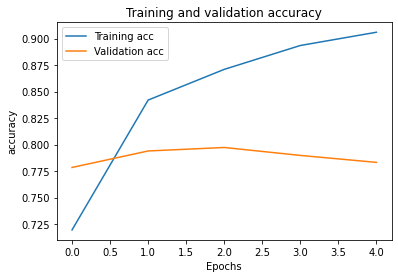

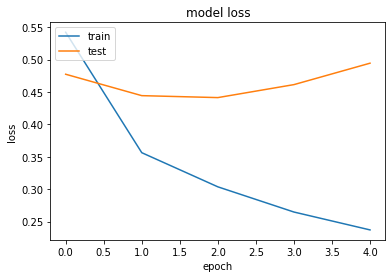

32/32 [==============================] - 1s 14ms/step
                         precision    recall  f1-score   support

        Not informative       0.33      0.29      0.31       373
Related and informative       0.60      0.64      0.62       627

               accuracy                           0.51      1000
              macro avg       0.47      0.47      0.47      1000
           weighted avg       0.50      0.51      0.51      1000

INFO:tensorflow:Assets written to: /tmp/tmp258rk_in/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp258rk_in/model/data/model/assets
2022/05/31 18:40:15 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/31 18:40:20 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/31 18:40:20 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0

Epoch 1/5
297/297 [==============================] - 68s 230ms/step - loss: 0.2134 - accuracy: 0.9171 - precision_5: 0.9306 - recall_5: 0.9349 - val_loss: 0.5284 - val_accuracy: 0.7700 - val_precision_5: 0.8306 - val_recall_5: 0.7318
Epoch 2/5
297/297 [==============================] - 64s 214ms/step - loss: 0.1934 - accuracy: 0.9249 - precision_5: 0.9380 - recall_5: 0.9399 - val_loss: 0.5543 - val_accuracy: 0.7757 - val_precision_5: 0.7932 - val_recall_5: 0.8018
Epoch 3/5
297/297 [==============================] - 64s 217ms/step - loss: 0.1812 - accuracy: 0.9296 - precision_5: 0.9420 - recall_5: 0.9436 - val_loss: 0.5805 - val_accuracy: 0.7709 - val_precision_5: 0.7862 - val_recall_5: 0.8024
Epoch 4/5
297/297 [==============================] - 63s 212ms/step - loss: 0.1642 - accuracy: 0.9375 - precision_5: 0.9486 - recall_5: 0.9498 - val_loss: 0.6558 - val_accuracy: 0.7620 - val_precision_5: 0.8016 - val_recall_5: 0.7546
Epoch 5/5
297/297 [==============================] - 64s 216ms/s

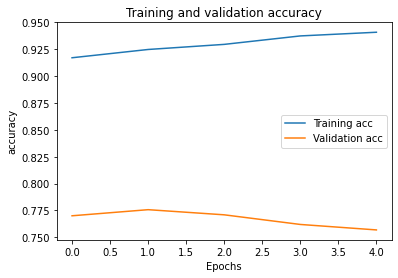

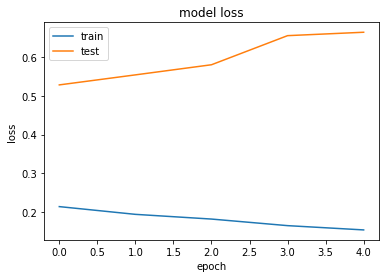

69/69 [==============================] - 1s 13ms/step
                         precision    recall  f1-score   support

        Not informative       0.46      0.45      0.46       841
Related and informative       0.67      0.68      0.67      1359

               accuracy                           0.59      2200
              macro avg       0.57      0.56      0.57      2200
           weighted avg       0.59      0.59      0.59      2200

INFO:tensorflow:Assets written to: /tmp/tmpk9nb6_y3/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpk9nb6_y3/model/data/model/assets
2022/05/31 18:46:57 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/31 18:47:03 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.0+zzzcolab20220506162203) contains a local version label (+zzzcolab20220506162203). MLflow logged a pip requirement for this package as 'tensorflow==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/31 18:47:03 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0

Epoch 1/5
297/297 [==============================] - 63s 214ms/step - loss: 0.1433 - accuracy: 0.9454 - precision_5: 0.9562 - recall_5: 0.9549 - val_loss: 0.7049 - val_accuracy: 0.7497 - val_precision_5: 0.7841 - val_recall_5: 0.7530
Epoch 2/5
297/297 [==============================] - 63s 213ms/step - loss: 0.1329 - accuracy: 0.9502 - precision_5: 0.9607 - recall_5: 0.9583 - val_loss: 0.8117 - val_accuracy: 0.7557 - val_precision_5: 0.7808 - val_recall_5: 0.7736
Epoch 3/5
297/297 [==============================] - 63s 212ms/step - loss: 0.1263 - accuracy: 0.9520 - precision_5: 0.9617 - recall_5: 0.9602 - val_loss: 0.7624 - val_accuracy: 0.7566 - val_precision_5: 0.7683 - val_recall_5: 0.7991
Epoch 4/5
297/297 [==============================] - 64s 215ms/step - loss: 0.1188 - accuracy: 0.9545 - precision_5: 0.9634 - recall_5: 0.9626 - val_loss: 0.8342 - val_accuracy: 0.7440 - val_precision_5: 0.7856 - val_recall_5: 0.7362
Epoch 5/5
297/297 [==============================] - 61s 207ms/s

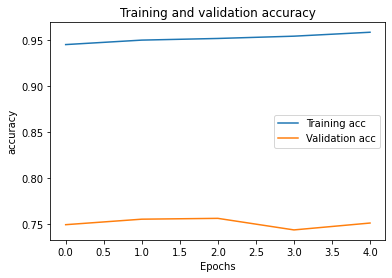

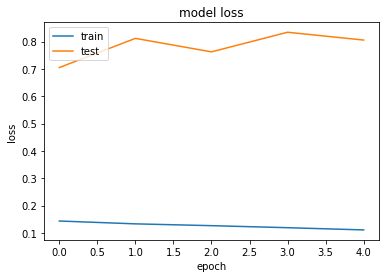

32/32 [==============================] - 0s 13ms/step
                         precision    recall  f1-score   support

        Not informative       0.28      0.46      0.35       271
Related and informative       0.74      0.56      0.64       729

               accuracy                           0.53      1000
              macro avg       0.51      0.51      0.49      1000
           weighted avg       0.61      0.53      0.56      1000



In [18]:
for parameter in dict_parameters:
  print(parameter)
  # define the model
  model = create_lstm(vocabulary_size, max_length, parameter['dropout'], parameter['learning_rate'])
  for cat in df_test.categorization_type.unique(): 
      tmp = df_test[df_test['categorization_type'] == cat]
      X_test = tmp['tweettext_proc'].values 
      y_test = np.where(tmp.cat_informativeness =='Related and informative', 1, 0)
      # fit the model
      with mlflow.start_run(): 
        mlflow_log_parameters(cat, parameter)
        mlflow.keras.log_model(model, "Lstm")
        history = model.fit(padded_docs_train, np.array(y_train), epochs= parameter['epochs'], batch_size=parameter['batch_size'], validation_split=.15)
        training_test_mae( mlflow, history)
        #Testing
        padded_docs = get_input(X_test, vocabulary_size, max_length)
        y_pred = model.predict(padded_docs, verbose=True)
        accuracy, precision, recall, f1score, mauc = evaluate(y_test, y_pred, mlflow)
        mlflow.end_run()